In [223]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import cycle
import plotly.graph_objects as go

idx = pd.IndexSlice

# LOAD DATA


In [224]:
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_benchmark_df

eval_df = load_benchmark_df("../data/evaluation/benchmarking/default")
scenario_df = load_scenario_df("../data/definition/routes_devtest_sliced.xml")

# join scenario and evaluation data
df = eval_df.join(scenario_df, on='route_index', how='inner').sort_index()

# PROCESS DATA


In [225]:
# drop infractions data
df = df.loc[:, ~df.columns.str.startswith('infractions')]

# reorder index so repetitions are last
df = df.reset_index().set_index(
    ['fps', 'highquality', 'route_index', 'rep']).sort_index()

# VISUALISE


## Old plot for RQ1


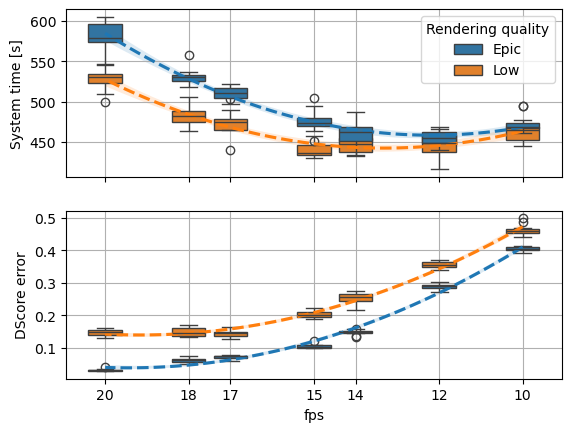

In [226]:
def new_boxplot(agg, ax, col='driving_score_error'):

    epicq = agg.xs("True", level='highquality',
                   drop_level=False).reset_index()
    lowq = agg.xs("False", level='highquality',
                  drop_level=False).reset_index()

    ax = sns.boxplot(lowq, x='fps', y=col, hue='highquality', ax=ax, native_scale=True, hue_order=["True", "False"]
                     )

    ax = sns.boxplot(epicq, x='fps', y=col,
                     hue='highquality', ax=ax,  native_scale=True, hue_order=["True", "False"])

    ax = sns.regplot(epicq, x='fps', y=col, ax=ax,
                     order=2, scatter=False, line_kws=dict(linestyle='dashed'),)

    ax = sns.regplot(lowq, x='fps', y=col, ax=ax,  order=2,
                     scatter=False, line_kws=dict(linestyle='dashed'),)


def make_boxplots(df):

    agg = df[['driving_score_error', 'duration_system']].groupby(
        ['fps', 'highquality', "rep"]).mean()

    vals = set(agg.reset_index()['fps'].values)

    f, axes = plt.subplots(nrows=2, sharex=True,)
    axes[0].invert_xaxis()

    axes[0].set_ylabel(f"System time [s]")
    new_boxplot(agg, ax=axes[0], col='duration_system')
    axes[0].grid()
    axes[0].set_xticks(list(vals))
    axes[0].set_ylabel(f"System time [s]")

    new_boxplot(agg, ax=axes[1], col='driving_score_error')
    axes[1].get_legend().remove()
    axes[1].grid()
    axes[1].set_ylabel(f"DScore error")

    handles, _ = axes[0].get_legend_handles_labels()

    axes[0].legend(handles=handles, labels=["Epic", "Low"],
                   title="Rendering quality")

    # f.savefig('plot_rq12.pdf', bbox_inches='tight')


make_boxplots(df)

## Are low fid benefictial for robust scenarios?


### Label fidelity robustness

Based on averaged DScore error


In [227]:
# average the data across repetitions
data = df.select_dtypes('number').groupby(
    ['fps', "highquality", 'route_index']).mean()


safe_threshold = 0.01
risky_threshold = 0.25

data.loc[:, 'label'] = np.select(
    [data['driving_score_error'] < safe_threshold,
     data['driving_score_error'].between(safe_threshold, risky_threshold),
     data['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

### Crease mask of safe scenarios


In [228]:
safety_mask = data['label'] == 'safe'
# safety_mask

### Plot


/tmp/ipykernel_76718/1679077455.py:25: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



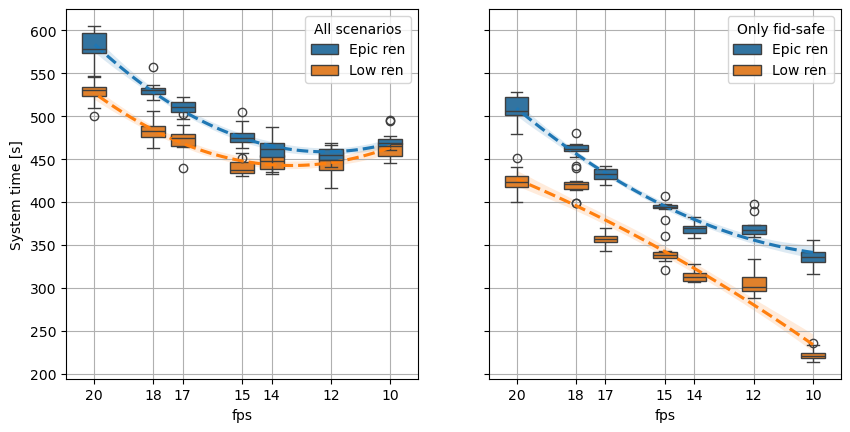

In [229]:
f, axes = plt.subplots(ncols=2, sharex=True, sharey=True)
f.set_figwidth(10)

axes[0].invert_xaxis()

axes[0].set_ylabel(f"System time [s]")
vals = set(df.reset_index()['fps'].values)
axes[0].set_xticks(list(vals))


def draw_subplot(ax, df, title):
    ax.grid()
    agg = df.select_dtypes('number').groupby(
        ['fps', 'highquality', "rep"]).mean()
    new_boxplot(agg, ax, col='duration_system')

    ax.set_ylabel(f"System time [s]")
    handles, _ = ax.get_legend_handles_labels()

    ax.legend(handles=handles, labels=["Epic ren", "Low ren"],
              title=title)


draw_subplot(axes[0], df, "All scenarios")
draw_subplot(axes[1], df[safety_mask], "Only fid-safe")

### Conclusion

For safe scenarios low fidelity is showing a REAL benefit/potential


## Robustness distribution


In [230]:
def draw_dist(data):

    data = data.reset_index()
    data['fps'] = data['fps'].astype(str)

    fig, (ax1,  ax2) = plt.subplots(1, 2, sharex=True)
    fig.set_figwidth(15)

    sns.histplot(
        data, x="fps", hue='label', hue_order=['risky', 'moderate', 'safe'], multiple="stack",  shrink=.8, ax=ax1
    )

    sns.stripplot(data, x='fps', y='driving_score_error', hue='label', hue_order=['risky', 'moderate', 'safe'],
                  ax=ax2)
    ax2.set_ylabel("DScore error")

### All scenarios


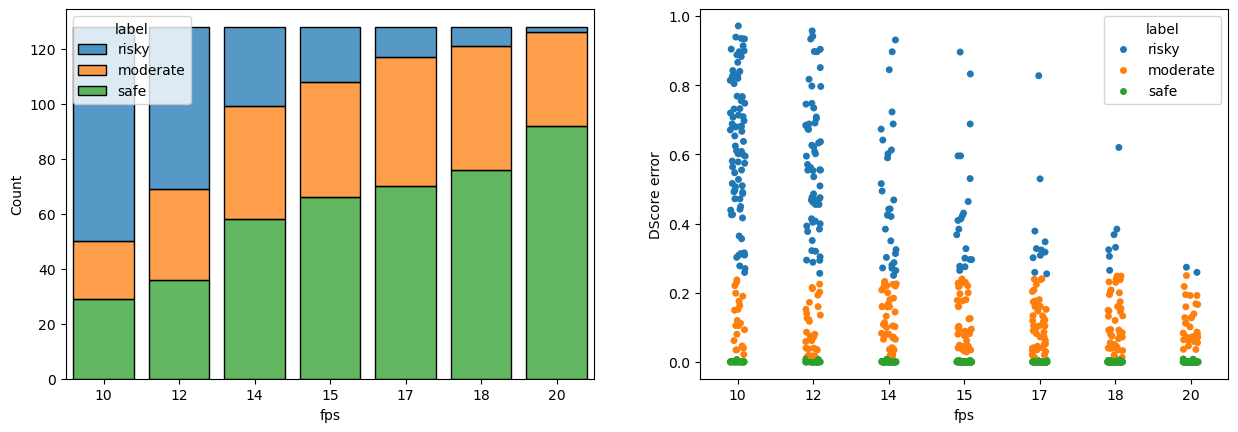

In [231]:
epic = data.xs("True", level='highquality')
draw_dist(epic)

### Non-flakey scenarios


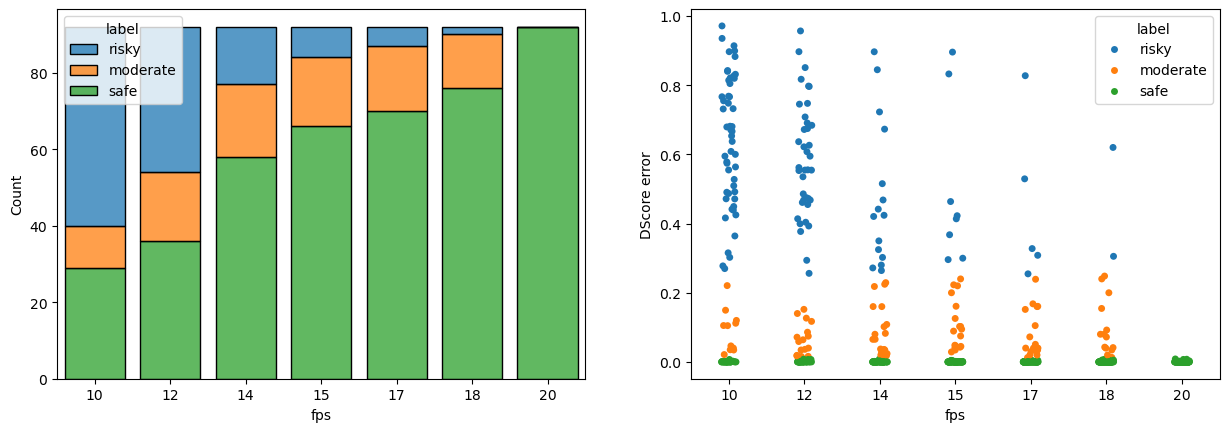

In [232]:
highfid = epic.xs(20, level='fps')
safe_mask = highfid['label'] == 'safe'
# safe_mask
nonflakey = epic.where(safe_mask).dropna()

draw_dist(nonflakey)

## Robust flow - Sankey diagram


### Sankey tooling


#### Transition class


In [233]:
from itertools import product
from dataclasses import dataclass


@dataclass
class Transition:
    """Class for keeping track of an item in inventory."""
    source_fps: str
    source_label: str
    target_fps: str
    target_label: str
    value: int

    @property
    def source(self) -> str:
        return f"{self.source_fps} {self.source_label}"

    @property
    def target(self) -> str:
        return f"{self.target_fps} {self.target_label}"

    def __str__(self) -> str:
        return f'For {self.source_fps} {self.source_label} -> {self.target_fps} {self.target_label}: {self.value}'

#### Make sankey transitions


In [234]:
def make_sankey_transitions(sankey_data) -> list[Transition]:

    transitions: list[Transition] = []

    # reversing at the end
    batches = list(sankey_data.groupby('fps'))[::-1]

    # outer loop iterates over pairs of fps values (20, 18), (18, 17), (17, 15)...
    for (source_fps, source_batch), (target_fps, target_batch) in zip(batches, batches[1:]):

        source_batches = list(source_batch.groupby('label'))
        target_batches = list(target_batch.groupby('label'))

        # inner loop iterates over pairs (safe, safe), (safe, moderate) ... to capture transitions
        for (source_label, source_label_batch),  (target_label, target_label_batch) in product(source_batches, target_batches):

            # merge batches with inner to calculate intersection between them
            merged = pd.merge(source_label_batch, target_label_batch,
                              how='inner', on=['route_index'])

            # size of merged is transition value
            value = merged.shape[0]
            t = Transition(source_fps, source_label,
                           target_fps, target_label, value)
            # print(t)
            transitions.append(t)

    return transitions

In [235]:
def process_sankey_transitions(transitions: list[Transition]):

    figure_labels = [(t.source, t.target) for t in transitions]
    figure_labels = {x for xs in figure_labels for x in xs}
    figure_labels = list(figure_labels)
    figure_labels = sorted(figure_labels, reverse=True)
    fl_index_mapping = {fg: i for i, fg in enumerate(figure_labels)}
    fl_index_mapping

    colors = cycle(['rgb(0, 200, 0)', 'rgb(200, 0, 0)',  'rgb(0, 0, 200)'])
    fl_color_mapping = dict(zip(figure_labels, colors))
    # fl_color_mapping

    links = np.array([(fl_index_mapping[t.source], fl_index_mapping[t.target], t.value)
                      for t in transitions])
    links = links.T

    return fl_index_mapping, fl_color_mapping, links

### Insert data


In [236]:
fps_values = [10, 15, 20]
highquality = "True"
sankey_data = data.loc[idx[fps_values, highquality], :]

### Plot flows


In [237]:
transitions = make_sankey_transitions(sankey_data)
fl_index_mapping, fl_color_mapping, links = process_sankey_transitions(
    transitions)

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="green", width=0.5),
        label=list(fl_index_mapping.keys()),
        customdata=list(fl_index_mapping.keys()),
        hovertemplate='%{customdata} has total value %{value}<extra></extra>',
        color=list(fl_color_mapping.values())
    ),
    link=dict(
        arrowlen=0,
        source=links[0],
        target=links[1],
        value=links[2],
        hovertemplate=' ',
    ))])

fig.update_layout(font_size=20)